# Run all the cells to get the plots
- Just enter the config file names 
    - [Here](#config_random_mnist_path), for random label mnist 
    - [Here](#config_non_random_mnist_path), for non-random label mnist 


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import get_config

# Some Functions

In [2]:
#########################################
#  Some unused functoins
#########################################

def plot_all(train_df, s_times = 10, r_times=2, figsize = (18, 6)):

    figure, axis = plt.subplots(r_times, s_times, figsize=figsize)

    for r_id in range(r_times):
        for s_id in range(s_times):
            temp_df = train_df[(train_df['s_id']==s_id) &
                               (train_df['r_id']==r_id)]
            temp_df.plot(y=['train_loss', 'train_acc'], x='epoch', ax=axis[r_id, s_id])
            axis[r_id, s_id].set_title(f'r_id:{r_id}, s_id:{s_id}')
            #temp_df.plot(y=['train_loss'], x='epoch', ax=axis[r_id, s_id])
    plt.show()

def e_f_given_sr(prob_df, s_id, r_id, label =0):
    # E_{X,Y}[f(r,S,X,Y)]
    # E_{X}[f(r,S,X,y_i)] when label is given

    if label is not None:
        temp_df = prob_df[(prob_df['r_id'] == r_id) & (prob_df['s_id']==s_id) & (prob_df['label']==label)]
    else:
        temp_df =  prob_df[(prob_df['r_id'] == r_id) & (prob_df['s_id']==s_id)]
    e_f = temp_df['loss'].mean()
    return e_f

def e_f_given_r(prob_df, r_id, label = 0):
    s_ids = list(prob_df['s_id'].unique())
    e_f = []
    for s_id in s_ids:
        e_f.append(e_f_given_sr(prob_df, s_id, r_id, label))
    
    print(f'Exp_(s,x)[f(s,x,{label})] = ',np.mean(e_f))

    return np.mean(e_f)

def e_f(prob_df, label = 0):
    r_ids = list(prob_df['r_id'].unique())
    e_f = []
    for r_id in r_ids:
        e_f.append(e_f_given_r(prob_df, r_id, label))

    print(f'Exp_(r,s,x)[f(s,x,{label})] = ',np.mean(e_f))
    return e_f

def var_f_given_r(prob_df, r_id):
    # Var_{S}[ E_{X,Y}[ f(r,S,X,Y) ] ]
    s_ids = list(prob_df['s_id'].unique())
    f_op = []
    for s_id in s_ids:
        f_op.append(e_f_given_sr(prob_df, s_id, r_id, label=None))
    
    return np.var(f_op)

def var_f(prob_df):
    r_ids = list(prob_df['r_id'].unique())
    var_f_op = []
    for r_id in r_ids:
        var_f_op.append(var_f_given_r(prob_df, r_id))
    
    return var_f_op

def var_risk_given_r_by_m(prob_df, r_id, m_list = None):
    ## Var_{S}(E_{X,y}[f(r,S,X,Y)]) given r grouped by |S| = m
    if m_list is None:
        m_list = prob_df['m'].unique()
    e_f = []
    for m in m_list:
        e_f.append(var_f_given_r(prob_df[prob_df['m'] == m], r_id))

    return e_f

def var_risk_multiple_exp(prob_df):
    r_ids = list(prob_df['r_id'].unique())
    m_list = list(prob_df['m'].unique())
    var_exp_wise = []
    for r_id in r_ids:
        var_exp_wise.append(var_risk_given_r_by_m(prob_df, r_id, m_list))

    return var_exp_wise, m_list

#########################################
# End of unused functions
#########################################



#########################################
# Fucntions required for plotting 
#########################################

def get_var_df(prob_df):
    # given for every m,r_id it gives max_{z} Var_{S}[f(r,S,z)]

    z_ids = prob_df['z_id'].unique()
    r_ids = prob_df['r_id'].unique()
    m_list = prob_df['m'].unique()


    var_s_dict = {}
    var_s_dict['r_id'] = []
    var_s_dict['m'] = []
    var_s_dict['var_s_given_mr'] = []

    for r_id in r_ids:
        for m in m_list: 
            temp_prob_df = prob_df[(prob_df['r_id']==r_id) & (prob_df['m']==m)]
            var_s_given_zmr = []
            for z_id in z_ids:
                s_times = temp_prob_df[temp_prob_df['z_id']==z_id]['loss'].shape
                #print(f's_times:{s_times}?')
                var_s_given_zmr.append(temp_prob_df[temp_prob_df['z_id']==z_id]['loss'].var())
            var_s_given_mr = max(var_s_given_zmr)
            var_s_dict['r_id'].append(r_id)
            var_s_dict['m'].append(m)
            var_s_dict['var_s_given_mr'].append(var_s_given_mr)
    
    var_s_df = pd.DataFrame(var_s_dict)
    return var_s_df


## Some related functions
def get_fro_norm(prob_df):
    cols =['fro0','fro1','fro2','fro3']
    prob_df['f_norm'] = 0
    for col in cols:
        prob_df['f_norm'] += prob_df[col]**2
    prob_df['f_norm'] = np.sqrt(prob_df['f_norm'])
    # return prob_df

def get_spe_norm(prob_df):
    cols =['spe0','spe2']
    prob_df['s_norm'] = 1
    for col in cols:
        prob_df['s_norm'] *= prob_df[col]

def get_avg_grads(prob_df):

    ## Given r,m,s pick top z with max norm values
    avg_over_s = {}
    avg_over_s['m'] = []
    avg_over_s['r_id'] = []
    avg_over_s['f_norm'] = []
    avg_over_s['s_norm'] = []

    ## Pick worst z values
    max_norms_perS = prob_df.groupby(['r_id', 'm','s_id'], as_index=False)['f_norm', 's_norm'].max()
    r_ids = max_norms_perS['r_id'].unique()
    m_list = max_norms_perS['m'].unique()
    for r_id in r_ids:
        for m in m_list:
            temp_df = max_norms_perS[(max_norms_perS['r_id']==r_id) &(max_norms_perS['m']==m)]
            # print('temp df', temp_df)
            avg_over_s['m'].append(m)
            avg_over_s['r_id'].append(r_id)

            avg_f_norm = temp_df['f_norm'].mean()
            avg_s_norm = temp_df['s_norm'].mean()
            avg_over_s['f_norm'].append(avg_f_norm)
            avg_over_s['s_norm'].append(avg_s_norm)
    return pd.DataFrame(avg_over_s)


#########################################
# End of Fucntions required for plotting 
#########################################




# Experiment 3 plots 

## Random label case
ex2_mnist_l128_lr003_b8_mv2
<a id="config_random_mnist_path"></a>

In [3]:
#####################
# Put the correct config file path (if changed)
#####################

config = get_config('config_random_mnist.yaml')
root_folder = f'results/{config.exp_name}/' 
train_file = root_folder + config.train_file
train_df = pd.read_csv(train_file)

In [4]:
prob_file = root_folder + config.prob_file
prob_df = pd.read_csv(prob_file, index_col=None)

get_fro_norm(prob_df)
get_spe_norm(prob_df)

/tmp/ipykernel_37719/2869194538.py:149: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  max_norms_perS = prob_df.groupby(['r_id', 'm','s_id'], as_index=False)['f_norm', 's_norm'].max()


img saved at : ./exp3_mnist_plot.png


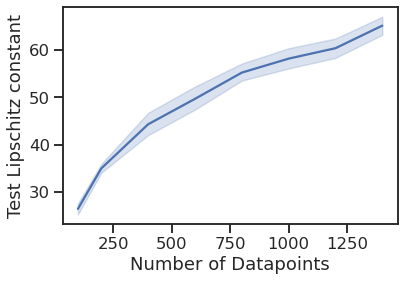

In [ ]:
avg_grads = get_avg_grads(prob_df)

sns.set_theme()
## Applying locally
with sns.axes_style('ticks'):
    sns.set_context('talk')
    sns.lineplot(x='m', y='f_norm', data=avg_grads)
    # plt.title('Max Lg over z, avg over randomness')
    plt.ylabel('Test Lipschitz constant')
    plt.xlabel('Number of Datapoints')
    lg_fnorm_path = 'exp3_mnist_plot.png' 
    plt.savefig(lg_fnorm_path, bbox_inches='tight', dpi=300)
    print(f'img saved at : ./{lg_fnorm_path}')
    plt.show()

# Computation using spectral norm, Not used for our experiment
# sns.lineplot(x='m', y='s_norm', data=avg_grads)
# plt.title('Max Lg over z, avg over randomness')
# plt.show()

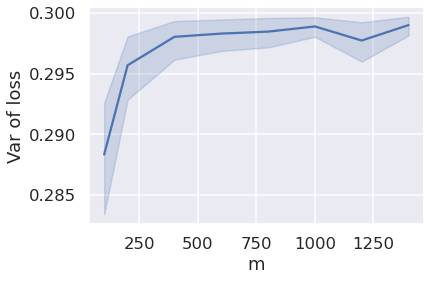

In [ ]:
var_s_df = get_var_df(prob_df)
var_s_df.head()

var_f_plt = sns.lineplot(x='m', y='var_s_given_mr', data=var_s_df)
plt.ylabel('Var of loss')
fig = var_f_plt.get_figure()
fig_path = root_folder + 'var_f_plot.png'
# fig.savefig(fig_path)
# print(f'plot saved at: ./{fig_path}')

## Good distribution (Non random case)
ex2_mnist_l128_lr003_b8_mv2_g

<a id="config_non_random_mnist_path"></a>

In [28]:
#####################
# Put the correct config file path (if changed)
#####################

config = get_config('config_good_mnist.yaml')
root_folder = f'results/{config.exp_name}/' 
train_file = root_folder + config.train_file
train_df = pd.read_csv(train_file)

In [29]:
prob_file = root_folder + config.prob_file
prob_df = pd.read_csv(prob_file, index_col=None)
get_fro_norm(prob_df)
get_spe_norm(prob_df)

/tmp/ipykernel_37719/2869194538.py:149: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  max_norms_perS = prob_df.groupby(['r_id', 'm','s_id'], as_index=False)['f_norm', 's_norm'].max()


img saved at : ./exp3_gmnist_plot.png


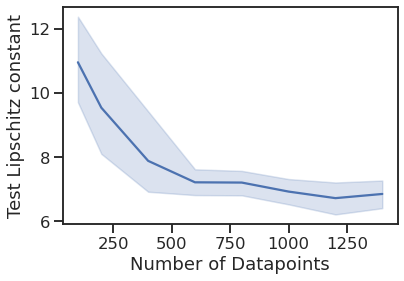

In [ ]:
avg_grads = get_avg_grads(prob_df)

sns.set_theme()
## Applying locally
with sns.axes_style('ticks'):
    sns.set_context('talk')
    sns.lineplot(x='m', y='f_norm', data=avg_grads)
    # plt.title('Max Lg over z, avg over randomness')
    plt.ylabel('Test Lipschitz constant')
    plt.xlabel('Number of Datapoints')
    lg_fnorm_path = 'exp3_gmnist_plot.png'
    plt.savefig(lg_fnorm_path, bbox_inches='tight', dpi=300)
    print(f'img saved at : ./{lg_fnorm_path}')
    plt.show()

# Computation using spectral norm, Not used for our experiment
# sns.lineplot(x='m', y='s_norm', data=avg_grads)
# plt.title('Non Random,  Max Lg over z, avg over randomness')
# plt.show()

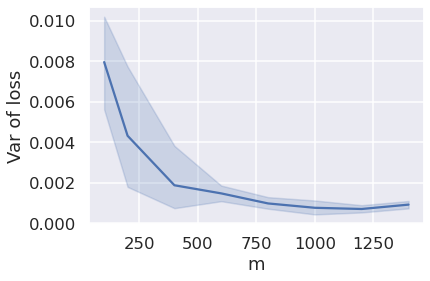

In [31]:
# Plot on variance, not in the paper
var_s_df = get_var_df(prob_df)
var_s_df.head()

var_f_plt = sns.lineplot(x='m', y='var_s_given_mr', data=var_s_df)
plt.ylabel('Var of loss')
fig = var_f_plt.get_figure()
fig_path = root_folder + 'var_f_plot.png'
# fig.savefig(fig_path)
# print(f'plot saved at: ./{fig_path}')